# Preparing Time Series Data
Like most preparation processes, but now with dates!

In [2]:
import pandas as pd
from datetime import timedelta, datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from env import user, password, host
import os
# from acquire import wrangle_store_data

import warnings
warnings.filterwarnings("ignore")

# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

## Acquire
We'll start by loading up the data from mysql server.

In [3]:
# The following are functions contained in the accompanying acquire.py file

def get_db_url(database):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

def get_store_data():
    '''
    Returns a dataframe of all store data in the tsa_item_demand database and saves a local copy as a csv file.
    '''
    query = '''
    SELECT *
    FROM items
    JOIN sales USING(item_id)
    JOIN stores USING(store_id) 
    '''
    
    df = pd.read_sql(query, get_db_url('tsa_item_demand'))
    
    df.to_csv('tsa_item_demand.csv', index=False)
    
    return df

def wrangle_store_data():
    filename = 'tsa_store_data.csv'
    
    if os.path.isfile(filename):
        df = pd.read_csv(filename)
    else:
        df = get_store_data()
        
    return df

In [4]:
df = wrangle_store_data()

In [5]:
df.head()

,store_id,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_id,sale_date,sale_amount,store_address,store_zipcode,store_city,store_state
0,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,1,2013-01-01,13,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
1,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,2,2013-01-02,11,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
2,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,3,2013-01-03,14,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
3,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,4,2013-01-04,13,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
4,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,5,2013-01-05,10,12125 Alamo Ranch Pkwy,78253,San Antonio,TX


In [6]:
df.isnull().sum()

store_id         0
item_id          0
item_upc14       0
item_upc12       0
item_brand       0
item_name        0
item_price       0
sale_id          0
sale_date        0
sale_amount      0
store_address    0
store_zipcode    0
store_city       0
store_state      0
dtype: int64

In [7]:
df.store_id.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [8]:
df.item_id.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [9]:
df.sale_date.nunique()

1826

In [10]:
df.sale_date.min(), df.sale_date.max()

(datetime.date(2013, 1, 1), datetime.date(2017, 12, 31))

In [11]:
df.sale_amount.describe()

count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
25%          30.000000
50%          47.000000
75%          70.000000
max         231.000000
Name: sale_amount, dtype: float64

In [12]:
df.sale_date = pd.to_datetime(df.sale_date)
df = df.set_index("sale_date").sort_index()

In [13]:
df.head()

,store_id,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_id,sale_amount,store_address,store_zipcode,store_city,store_state
sale_date,,,,,,,,,,,,,
2013-01-01,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,1,13,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
2013-01-01,3,17,88313590791,88313590791,Ducal,Ducal Refried Red Beans,1.16,295813,26,2118 Fredericksburg Rdj,78201,San Antonio,TX
2013-01-01,10,7,70177154004,70177154004,Twinings Of London,Twinings Of London Classics Lady Grey Tea - 20 Ct,9.64,125995,32,8503 NW Military Hwy,78231,San Antonio,TX
2013-01-01,3,18,21200725340,21200725340,Scotch,Scotch Removable Clear Mounting Squares - 35 Ct,4.39,314073,45,2118 Fredericksburg Rdj,78201,San Antonio,TX
2013-01-01,3,19,41520035646,41520035646,Careone,Careone Family Comb Set - 8 Ct,0.74,332333,34,2118 Fredericksburg Rdj,78201,San Antonio,TX


In [14]:
df.shape[0], df.sale_id.nunique()

(913000, 913000)

<AxesSubplot:xlabel='sale_date'>

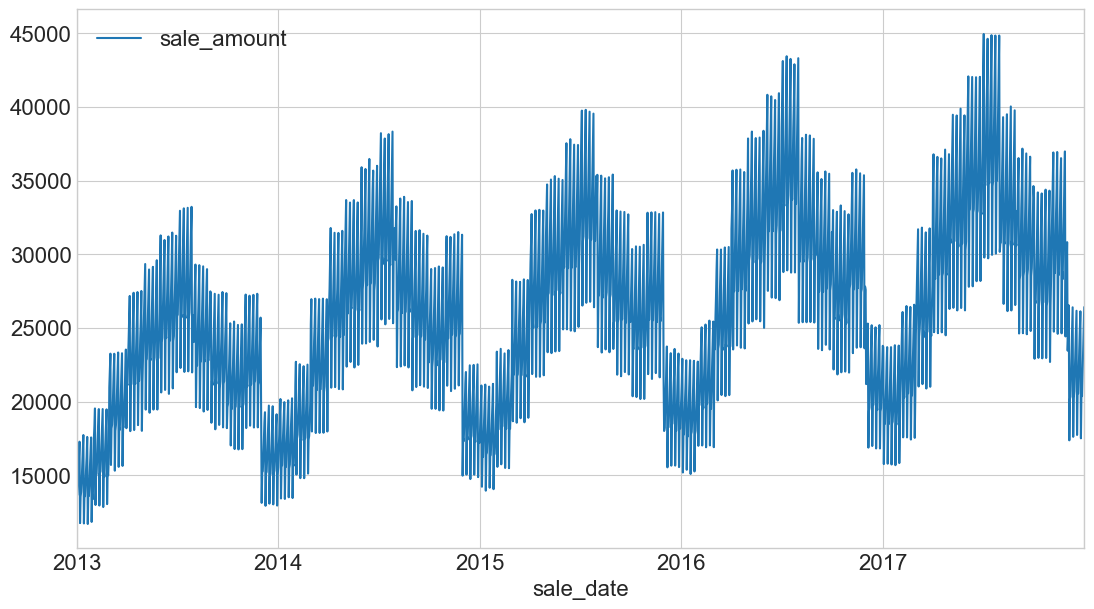

In [15]:
by_date = df.groupby(['sale_date']).sale_amount.sum().reset_index()
by_date.plot(x='sale_date', y='sale_amount')

In [16]:
df.store_id.value_counts()

1     91300
3     91300
10    91300
9     91300
2     91300
4     91300
6     91300
8     91300
7     91300
5     91300
Name: store_id, dtype: int64

In [17]:
df.item_id.value_counts().sort_index()

1     18260
2     18260
3     18260
4     18260
5     18260
6     18260
7     18260
8     18260
9     18260
10    18260
11    18260
12    18260
13    18260
14    18260
15    18260
16    18260
17    18260
18    18260
19    18260
20    18260
21    18260
22    18260
23    18260
24    18260
25    18260
26    18260
27    18260
28    18260
29    18260
30    18260
31    18260
32    18260
33    18260
34    18260
35    18260
36    18260
37    18260
38    18260
39    18260
40    18260
41    18260
42    18260
43    18260
44    18260
45    18260
46    18260
47    18260
48    18260
49    18260
50    18260
Name: item_id, dtype: int64

In [18]:
first_sale = df.reset_index().groupby(['store_id','item_id']).sale_date.min()
first_sale.head()

store_id  item_id
1         1         2013-01-01
          2         2013-01-01
          3         2013-01-01
          4         2013-01-01
          5         2013-01-01
Name: sale_date, dtype: datetime64[ns]

In [19]:
first_sale.unique()

array(['2013-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [20]:
last_sale = df.reset_index().groupby(['store_id','item_id']).sale_date.max()
last_sale.head()

store_id  item_id
1         1         2017-12-31
          2         2017-12-31
          3         2017-12-31
          4         2017-12-31
          5         2017-12-31
Name: sale_date, dtype: datetime64[ns]

In [21]:
last_sale.unique()

array(['2017-12-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [22]:
days_per_store_per_item = df.reset_index().groupby(['store_id','item_id']).sale_date.nunique()
days_per_store_per_item.head()

store_id  item_id
1         1          1826
          2          1826
          3          1826
          4          1826
          5          1826
Name: sale_date, dtype: int64

In [23]:
days_per_store_per_item.unique() 

array([1826])

In [24]:
print('Number of rows:', df.index.nunique())
n_days = df.index.max() - df.index.min() + pd.Timedelta('1d')
print(f"Number of days between first and last day:", n_days)

Number of rows: 1826
Number of days between first and last day: 1826 days 00:00:00


In [25]:
def prep_store_data(df):
    return df.asign(sale_date=pd.to_datetime(df.sale_date)).sort_values('sale_date').set_index('sale_date')

In [37]:
germany = pd.read_csv('https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv')
germany.to_csv('germany.csv')
germany

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.18400,NaN,NaN,NaN
1,2006-01-02,1380.52100,NaN,NaN,NaN
2,2006-01-03,1442.53300,NaN,NaN,NaN
3,2006-01-04,1457.21700,NaN,NaN,NaN
4,2006-01-05,1477.13100,NaN,NaN,NaN
...,...,...,...,...,...
4378,2017-12-27,1263.94091,394.507,16.530,411.037
4379,2017-12-28,1299.86398,506.424,14.162,520.586
4380,2017-12-29,1295.08753,584.277,29.854,614.131
4381,2017-12-30,1215.44897,721.247,7.467,728.714


In [59]:
germany['Date'] =  pd.to_datetime(germany['Date'])

In [61]:
germany = germany.set_index("Date").sort_index()

In [65]:
germany.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184,NaN,NaN,NaN
2006-01-02,1380.521,NaN,NaN,NaN
2006-01-03,1442.533,NaN,NaN,NaN
2006-01-04,1457.217,NaN,NaN,NaN
2006-01-05,1477.131,NaN,NaN,NaN


<AxesSubplot:xlabel='Date'>

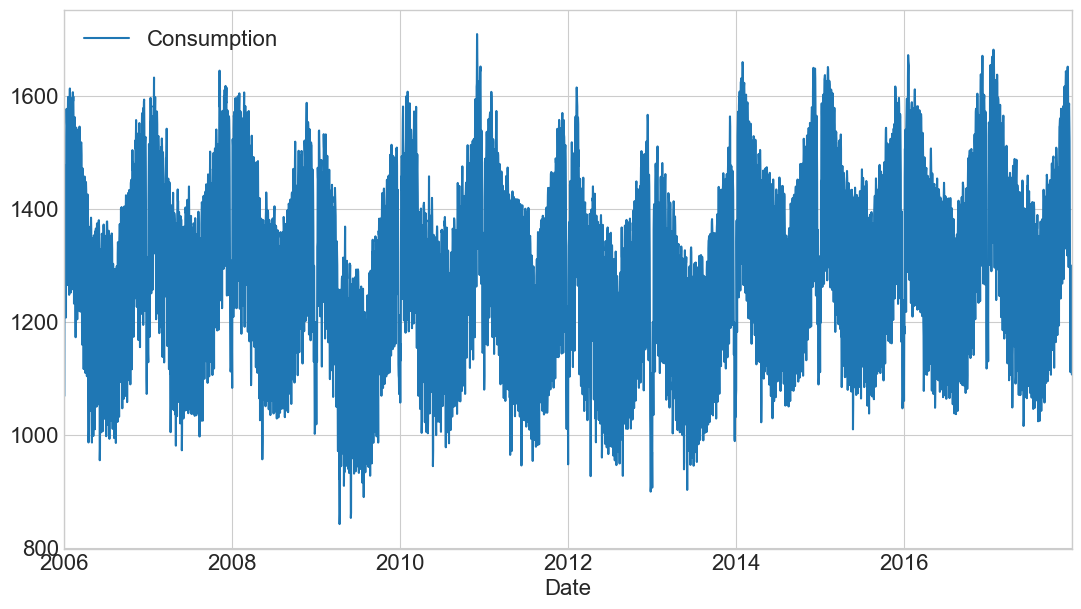

In [69]:
by_date = germany.groupby(['Date']).Consumption.sum().reset_index()
by_date.plot(x='Date', y='Consumption')

In [70]:
germany.fillna(0, inplace = True)

In [75]:
germany.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184,0.0,0.0,0.0
2006-01-02,1380.521,0.0,0.0,0.0
2006-01-03,1442.533,0.0,0.0,0.0
2006-01-04,1457.217,0.0,0.0,0.0
2006-01-05,1477.131,0.0,0.0,0.0


In [86]:
germany['month']=germany.index.month

In [87]:
germany['year']=germany.index.year

In [88]:
germany.head()

,Consumption,Wind,Solar,Wind+Solar,month,year
Date,,,,,,
2006-01-01,1069.184,0.0,0.0,0.0,1,2006
2006-01-02,1380.521,0.0,0.0,0.0,1,2006
2006-01-03,1442.533,0.0,0.0,0.0,1,2006
2006-01-04,1457.217,0.0,0.0,0.0,1,2006
2006-01-05,1477.131,0.0,0.0,0.0,1,2006
